In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.model import SIREN
from src.laplacian import *
from scipy import sparse
import matplotlib.animation as animation
from src.diff_operators import gradient, divergence

In [ ]:
def evaluate( model, samples, max_batch=64**2, device=torch.device(0) ):
    # samples = ( amount_samples, 3 )    
    head = 0
    amount_samples = samples.shape[0]

    evaluations = np.zeros( (amount_samples, 1))
    gradients = np.zeros( (amount_samples, 2))
    totalvariation = np.zeros( (amount_samples, 2))
    laplacians = np.zeros( (amount_samples, 1))

    while head < amount_samples:        
        if torch.is_tensor(samples):
            inputs_subset = samples[head:min(head + max_batch, amount_samples), :]
        else:

            inputs_subset = torch.from_numpy(samples[head:min(head + max_batch, amount_samples), :]).float()
            
        inputs_subset = inputs_subset.to(device).unsqueeze(0)

        x, y =  model(inputs_subset).values()
        subset_grad = gradient(y,x)
        gradients[head:min(head + max_batch, amount_samples)] = subset_grad.squeeze(0).detach().cpu().numpy()[..., :]
        totalvariation[head:min(head + max_batch, amount_samples)] = gradient(subset_grad.norm(dim=-1), x ).squeeze(0).detach().cpu().numpy()
        laplacians[head:min(head + max_batch, amount_samples)] = divergence( subset_grad, x ).squeeze(0).detach().cpu().numpy()[..., :]
        evaluations[head:min(head + max_batch, amount_samples)] = y.squeeze(0).detach().cpu()
        head += max_batch

    return evaluations, gradients, laplacians, totalvariation

model = SIREN(
        n_in_features= 2,
        n_out_features=1,
        hidden_layer_config=[64]*6,
        w0=30,
        ww=None,
        activation= 'sine'
)
model.load_state_dict( torch.load('results/bezier/experiment/models/model_best.pth', weights_only=True))

device = torch.device(1)
model.to(device)

N = 256
xs, ys = np.meshgrid( np.linspace(-1,1,N), np.linspace(-1,1,N) )
X = np.concatenate( [ xs.flatten()[...,None], ys.flatten()[...,None] ] , axis=1)

fX, dfX, LfX, tv = evaluate(  model, X, device=device )

In [ ]:
#u0 = np.eye( 1,N**2, k=( np.arange(0, N**2)[ np.abs(fX).flatten() < 1e-3] )[3] )
index = ( np.arange(0, N**2)[ np.abs(fX).flatten() < 1e-3] )[10]
mu = X[index, :]

normal = dfX[ index, :]
normal /= np.linalg.norm( normal )
tangent = np.random.uniform( 0 ,1, 2 )
tangent -= ( tangent @ normal ) * normal
tangent /= np.linalg.norm(tangent)

P = np.vstack( [normal, tangent] )
sigma1, sigma2 = 1e-3, 1e-4

A = P.T @ np.diag( [1/sigma1 ** 2, 1/sigma2 ** 2] ) @ P
x_p = X - np.tile( mu, (len(X),1))
u0 = np.exp( - (x_p.dot(A)*x_p).sum(axis=1))

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
clip_val = min( np.abs(np.min(fX)), np.abs(np.max(fX)) )

axs[0][0].scatter(X[:,0], X[:,1], c=fX, cmap='bwr', vmin=-clip_val, vmax= clip_val)
axs[0][1].scatter(X[:,0], X[:,1], c=np.sum( dfX ** 2, axis=1), cmap='plasma')
axs[1][0].scatter(X[:,0], X[:,1], c=LfX, cmap='viridis')
axs[1][1].scatter(X[:,0], X[:,1], c=u0, cmap='viridis')

axs[0][0].set_title(r'$f(\vec{x})$')
axs[0][1].set_title(r'$\left \| \nabla f(\vec{x}) ) \right \|$')
axs[1][0].set_title(r'$\Delta f(\vec{x})$')
axs[1][1].set_title(r'$u(0)$')

plt.tight_layout()
plt.show()

In [ ]:
def integrator( L, u0, t, steps=1, method='backward'):
    I = sparse.csr_matrix( (N**2, N**2) )
    I.setdiag( np.ones(N ** 2), k=0 )

    ut = u0

    for step in range(steps):
        if method=='forward':
            ut = (I + t * L) @ ut
        
        elif method == 'backward':
            ut = sparse.linalg.spsolve( (I - t * L ), ut )
        
        elif method =='rk4':
            k1 = (L) @ ut
            k2 = (L) @ (ut + 0.5 * t * k1)
            k3 = (L) @ (ut + 0.5 * t * k2)
            k4 = (L) @ (ut + t * k3)
            
            ut = ut + (t/6) * (k1 + 2*k2 + 2*k3 + k4)
        
        else:
            raise ValueError('Uknown integrator method')
    
    return ut


In [ ]:
mask = np.sqrt(np.sum(dfX ** 2, axis=1) ).flatten() > -1

LB = gridLaplaceBeltramiBertalmio(N, fX, mask, boundary='dirichlet' )
#LB_TV = gridLaplaceBeltramiTV( N, dfX, LfX, tv, mask, boundary='neumann' )

h = 2 / (N-1)
t = h ** 2 * 5

#ut = integrator( LB, u0.flatten(), t, steps=10, method='backward' )
ut = [u0]
for i in range(100):
    ut.append( integrator( LB, ut[-1], t, method='backward' )  )

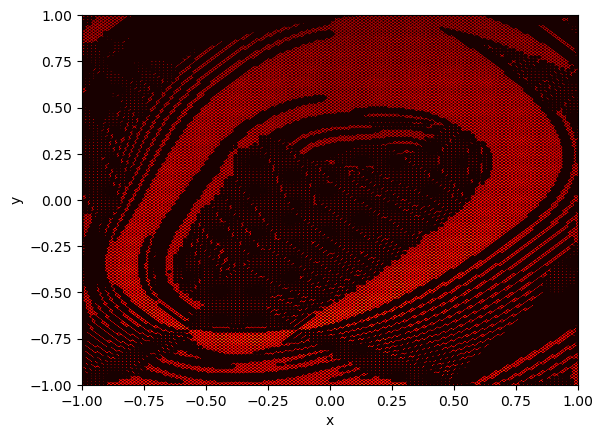

In [38]:
fig = plt.figure()
ax = plt.axes(xlim=(-1,1), ylim=(-1, 1), xlabel='x', ylabel='y')

x_unique = np.unique(X[:, 0])
y_unique = np.unique(X[:, 1])

varadhan = np.sqrt( -4 * t * np.log( np.clip( ut[0], a_min=1e-120, a_max=None ) ) )
nx, ny = len(x_unique), len(y_unique)
u_grid = varadhan.reshape(ny, nx)

vmin, vmax = varadhan.min(), varadhan.max()
num_levels = 20
levels = np.linspace(vmin, vmax, num_levels)

cont = plt.contourf(x_unique, y_unique, u_grid, levels=21, cmap='hot_r')
#axis = ax.contour(x_unique, y_unique, u_grid, colors='black', levels=levels)

def animate(i):
    varadhan = np.sqrt( -4 * t * np.log( np.clip( ut[i], a_min=1e-120, a_max=None ) ) )
    z = varadhan.reshape(ny, nx)
    
    cont = plt.contourf(x_unique, y_unique, z, 21, cmap='hot_r')

    return cont 


anim = animation.FuncAnimation(fig, animate, frames=50)

anim.save('animation_bertalmio.gif')

plt.show()